# APS360 Project

1. Load and split data for training, validation and testing
2. Creating Generator
3. Creating Discriminator
4. Training



# Landmark Libraries

## Part A. Data Loading

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import os
import shutil
from PIL import Image, ImageDraw
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn.utils import spectral_norm
import cv2
from CFA import CFA
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 1
LEARNING_RATE = 0.0002
LAMBDA_IDENTITY = 0.0  # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50
PM = 64
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_ANIME = "models/gen_anime"
CHECKPOINT_GENERATOR_HUMAN = "models/gen_human"
CHECKPOINT_DISCRIMINATOR_ANIME = "models/disc_anime"
CHECKPOINT_DISCRIMINATOR_HUMAN = "models/disc_human"

transforms = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


### 0. Helper Functions ###

In [32]:
###############################################################################
# Data Loading
import os
import random
import numpy as np
import pandas as pd
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler

class ImageBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer"
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

class AnimeHumanImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # Convert to NumPy array for albumentations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, 0  # Since there are no labels, we can return a dummy label (0)
    
def create_subset_dataset(original_dir, subset_dir, subset_size=100):
    """
    Creates a subset of the original dataset.
    
    Args:
        original_dir (str): Path to the original dataset directory.
        subset_dir (str): Path to the subset dataset directory.
        subset_size (int): Number of images to include in the subset.
    """
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    else:
        # Clear the subset directory
        for filename in os.listdir(subset_dir):
            file_path = os.path.join(subset_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    
    # Get all image paths
    image_paths = [os.path.join(original_dir, fname) for fname in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, fname))]
    
    # Shuffle and select a subset
    np.random.seed(1000)
    np.random.shuffle(image_paths)
    subset_paths = image_paths[:subset_size]
    
    # Copy images to the subset directory
    for img_path in subset_paths:
        shutil.copy(img_path, subset_dir)

    print(f"Subset created with {len(subset_paths)} images in {subset_dir}")

def get_data_loader(data_dir, batch_size, image_size=(128, 128), subset_size=None):
   # Define the transformation
    transform = A.Compose([
        A.Resize(width=image_size[0], height=image_size[1]),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ])
    
    # Verify the path
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    # Load the dataset
    dataset = AnimeHumanImageDataset(root_dir=data_dir, transform=transform)

    # Use a subset of the dataset if specified
    if subset_size:
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)
        subset_indices = indices[:subset_size]
        subset_sampler = SubsetRandomSampler(subset_indices)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler, num_workers=1)
        return loader

    # Function to split dataset indices
    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)  # Setting a seed for reproducibility
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    # Get split indices for the dataset
    train_indices, val_indices, test_indices = split_indices(dataset)

    # Create data loaders
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)

    return train_loader, val_loader, test_loader

def verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B):
    # Verify the split sizes for dataset A
    total_examples_A = len(train_loader_A.sampler) + len(val_loader_A.sampler) + len(test_loader_A.sampler)
    train_size_A = len(train_loader_A.sampler)
    val_size_A = len(val_loader_A.sampler)
    test_size_A = len(test_loader_A.sampler)

    train_proportion_A = train_size_A / total_examples_A
    val_proportion_A = val_size_A / total_examples_A 
    test_proportion_A = test_size_A / total_examples_A

    print(f"Dataset A - Total examples: {total_examples_A}")
    print(f"Dataset A - Train examples: {train_size_A} ({train_proportion_A:.2%})")
    print(f"Dataset A - Validation examples: {val_size_A} ({val_proportion_A:.2%})")
    print(f"Dataset A - Test examples: {test_size_A} ({test_proportion_A:.2%})")

    # Verify the split sizes for dataset B
    total_examples_B = len(train_loader_B.sampler) + len(val_loader_B.sampler) + len(test_loader_B.sampler)
    train_size_B = len(train_loader_B.sampler)
    val_size_B = len(val_loader_B.sampler)
    test_size_B = len(test_loader_B.sampler)

    train_proportion_B = train_size_B / total_examples_B
    val_proportion_B = val_size_B / total_examples_B 
    test_proportion_B = test_size_B / total_examples_B

    print(f"Dataset B - Total examples: {total_examples_B}")
    print(f"Dataset B - Train examples: {train_size_B} ({train_proportion_B:.2%})")
    print(f"Dataset B - Validation examples: {val_size_B} ({val_proportion_B:.2%})")
    print(f"Dataset B - Test examples: {test_size_B} ({test_proportion_B:.2%})")

    # Check for overlaps in dataset A
    train_indices_A = list(train_loader_A.sampler.indices)
    val_indices_A = list(val_loader_A.sampler.indices)
    test_indices_A = list(test_loader_A.sampler.indices)
    print("Checking overlaps for dataset A...")
    check_for_overlaps(train_indices_A, val_indices_A, test_indices_A)

    # Check for overlaps in dataset B
    train_indices_B = list(train_loader_B.sampler.indices)
    val_indices_B = list(val_loader_B.sampler.indices)
    test_indices_B = list(test_loader_B.sampler.indices)
    print("Checking overlaps for dataset B...")
    check_for_overlaps(train_indices_B, val_indices_B, test_indices_B)

def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
import glob

def evaluate(generator, discriminator, loader, criterion, device):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            
            # Generate fake images
            fake_images = generator(inputs)
            outputs = discriminator(fake_images)
            
            # Calculate loss
            loss = criterion(outputs, torch.ones_like(outputs).to(device))
            total_loss += loss.item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"=> Saving checkpoint to {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_latest_checkpoint(model, optimizer, checkpoint_prefix, lr, batch_size):
    checkpoint_files = glob.glob(f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_*.pth.tar")
    if not checkpoint_files:
        print(f"=> No checkpoint found for {checkpoint_prefix}. Starting from scratch.")
        return 0

    # Extract the latest epoch number from the checkpoint file names
    latest_epoch = max([int(file.split('_')[-1].split('.')[0]) for file in checkpoint_files])
    checkpoint_file = f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_{latest_epoch}.pth.tar"

    print(f"=> Loading checkpoint {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    return latest_epoch + 1

def get_model_name(model_type, epoch, learning_rate, batch_size):
    return f"models/{model_type}_lr{learning_rate}_bs{batch_size}_epoch_{epoch}.pth.tar"

def list_checkpoints(checkpoint_prefix):
    checkpoint_pattern = os.path.join(f"{checkpoint_prefix}_epoch_*.pth.tar")
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        print(f"No checkpoint found for prefix: {checkpoint_prefix}")
    else:
        print(f"Checkpoints found for prefix {checkpoint_prefix}:")
        for checkpoint in checkpoint_files:
            print(checkpoint)
            
def load_existing_data(csv_file):
    if os.path.exists(csv_file):
        return pd.read_csv(csv_file)
    else:
        return pd.DataFrame()

def save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, csv_file):
    existing_data = load_existing_data(csv_file)
    
    new_data = pd.DataFrame({
        'train_loss_anime': train_loss_anime_history,
        'train_loss_human': train_loss_human_history,
        'val_loss_anime': val_loss_anime_history,
        'val_loss_human': val_loss_human_history
    })

    combined_data = pd.concat([existing_data, new_data], ignore_index=True)
    combined_data.to_csv(csv_file, index=False)


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_loss_anime_file = f"{path}_train_loss_anime.csv"
    train_loss_human_file = f"{path}_train_loss_human.csv"
    val_loss_anime_file = f"{path}_val_loss_anime.csv"
    val_loss_human_file = f"{path}_val_loss_human.csv"

    train_loss_anime = np.loadtxt(train_loss_anime_file)
    train_loss_human = np.loadtxt(train_loss_human_file)
    val_loss_anime = np.loadtxt(val_loss_anime_file)
    val_loss_human = np.loadtxt(val_loss_human_file)

    plt.figure()
    plt.title("Train vs Validation Loss (Anime)")
    n = len(train_loss_anime)  # number of epochs
    plt.plot(range(1, n + 1), train_loss_anime, label="Train Anime")
    plt.plot(range(1, n + 1), val_loss_anime, label="Validation Anime")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss (Human)")
    plt.plot(range(1, n + 1), train_loss_human, label="Train Human")
    plt.plot(range(1, n + 1), val_loss_human, label="Validation Human")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    

### 1. Data Loading and Splitting 



### 1.1 Load Data ###

In [4]:
# Use (1000k photos) smaller subsets for quick testing
create_subset_dataset('/home/jempio/documents/aps360-project/data/dataSetA_10k', 'data/subset_dataSetA', subset_size=1000)
create_subset_dataset('/home/jempio/documents/aps360-project/data/dataSetB_10k', 'data/subset_dataSetB', subset_size=1000)

# Load data from the subsets
train_loader_A, val_loader_A, test_loader_A = get_data_loader('data/subset_dataSetA', BATCH_SIZE, image_size=(128, 128))
train_loader_B, val_loader_B, test_loader_B = get_data_loader('data/subset_dataSetB', BATCH_SIZE, image_size=(128, 128))

Subset created with 1000 images in data/subset_dataSetA
Subset created with 1000 images in data/subset_dataSetB


In [4]:
# # Load data from the full datasets
# train_loader_A, val_loader_A, test_loader_A = get_data_loader('/home/jempio/documents/aps360-project/data/dataSetA_10k', BATCH_SIZE, image_size=(128, 128))
# train_loader_B, val_loader_B, test_loader_B = get_data_loader('/home/jempio/documents/aps360-project/data/dataSetB_10k', BATCH_SIZE, image_size=(128, 128))

### 1.2 Verifying Split and Overlap ###

In [5]:
# Check for overlaps
verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B)

Dataset A - Total examples: 1000
Dataset A - Train examples: 700 (70.00%)
Dataset A - Validation examples: 150 (15.00%)
Dataset A - Test examples: 150 (15.00%)
Dataset B - Total examples: 1000
Dataset B - Train examples: 700 (70.00%)
Dataset B - Validation examples: 150 (15.00%)
Dataset B - Test examples: 150 (15.00%)
Checking overlaps for dataset A...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.
Checking overlaps for dataset B...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


### 1.3 Visualize Data ###

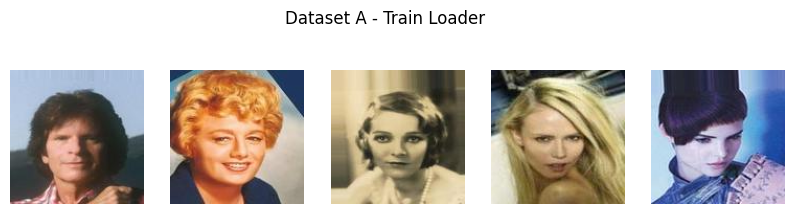

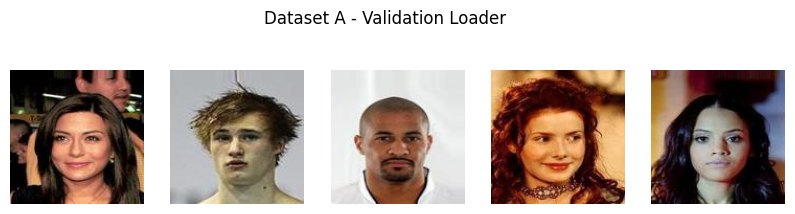

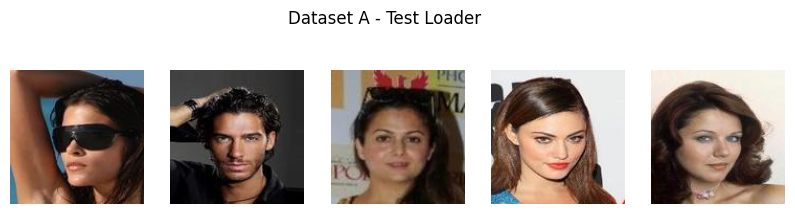

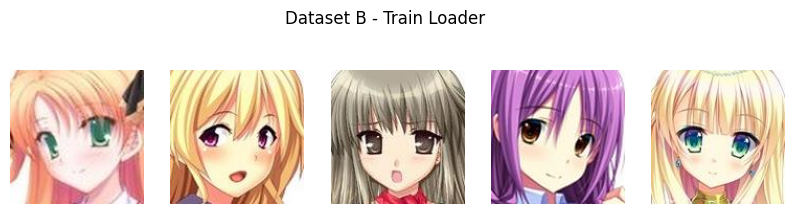

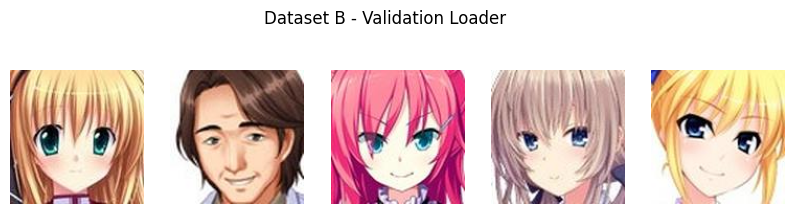

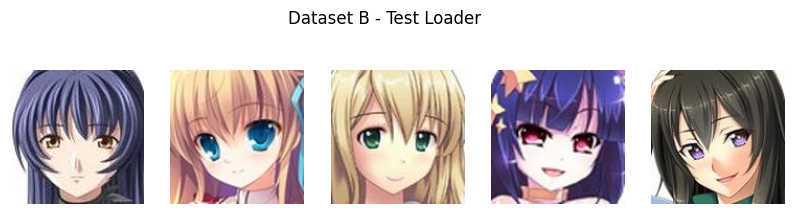

In [6]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=5):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

# Visualize dataset A
visualize_data_loader(train_loader_A, title="Dataset A - Train Loader")
visualize_data_loader(val_loader_A, title="Dataset A - Validation Loader")
visualize_data_loader(test_loader_A, title="Dataset A - Test Loader")

# Visualize dataset B
visualize_data_loader(train_loader_B, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_B, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")

# 2. Landmarking

## 2.1 Anime Landmarking


In [7]:
def draw_anime_landmarks(img_array, num_landmark, checkpoint_name, img_width):
    # Load face detector and landmark detector
    face_detector = cv2.CascadeClassifier('lbpcascade_animeface.xml')
    landmark_detector = CFA(output_channel_num=num_landmark + 1, checkpoint_name=checkpoint_name).cuda()

    # Convert numpy array to BGR image
    img = img_array.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Detect faces
    faces = face_detector.detectMultiScale(img)

    # Create a black image with the same size
    black_img = np.zeros_like(img)
    black_img = Image.fromarray(black_img)
    draw = ImageDraw.Draw(black_img)

    # Convert the original image to PIL Image for cropping
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    for x_, y_, w_, h_ in faces:
        # Adjust face size
        x = max(int(x_ - w_ / 8), 0)
        rx = min(int(x_ + w_ * 9 / 8), black_img.width)
        y = max(int(y_ - h_ / 4), 0)
        by = y_ + h_
        w = rx - x
        h = by - y

        # Draw result of face detection
        draw.rectangle((x, y, x + w, y + h), outline=(255, 255, 255), width=3)

        # Transform image
        img_tmp = img_pil.crop((x, y, x + w, y + h))
        img_tmp = img_tmp.resize((img_width, img_width), Image.BICUBIC)
        img_tmp = transforms.ToTensor()(img_tmp).unsqueeze(0).cuda()

        # Estimate heatmap
        heatmaps = landmark_detector(img_tmp)
        heatmaps = heatmaps[-1].cpu().detach().numpy()[0]

        landmarks = []

        # Calculate landmark position
        for i in range(num_landmark):
            heatmaps_tmp = cv2.resize(heatmaps[i], (img_width, img_width), interpolation=cv2.INTER_CUBIC)
            landmark = np.unravel_index(np.argmax(heatmaps_tmp), heatmaps_tmp.shape)
            landmark_y = landmark[0] * h / img_width
            landmark_x = landmark[1] * w / img_width

            landmarks.append((x + landmark_x, y + landmark_y))

            # Draw landmarks
            draw.ellipse((x + landmark_x - 2, y + landmark_y - 2, x + landmark_x + 2, y + landmark_y + 2), fill=(255, 255, 255))

        # Draw boxes around eyes, nose, and mouth
        # Adjust indices based on specific model
        eyebrow_left_indices = [3, 4, 5]
        eyebrow_right_indices = [6, 7, 8]
        eye_left_indices = [0, 10, 11, 12, 13, 14]
        eye_right_indices = [2, 15, 16, 17, 18, 19]
        nose_indices = [9]
        mouth_indices = [1, 20, 22, 23]

        def get_bounding_box(points):
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]
            return (min(x_coords), min(y_coords), max(x_coords), max(y_coords))

        if all(i < num_landmark for i in eyebrow_left_indices):
            eyebrow_left_points = [landmarks[i] for i in eyebrow_left_indices]
            draw.rectangle(get_bounding_box(eyebrow_left_points), outline=(0, 255, 0), width=2)

        if all(i < num_landmark for i in eyebrow_right_indices):
            eyebrow_right_points = [landmarks[i] for i in eyebrow_right_indices]
            draw.rectangle(get_bounding_box(eyebrow_right_points), outline=(0, 255, 0), width=2)

        if all(i < num_landmark for i in eye_left_indices):
            eye_left_points = [landmarks[i] for i in eye_left_indices]
            draw.rectangle(get_bounding_box(eye_left_points), outline=(0, 255, 0), width=2)

        if all(i < num_landmark for i in eye_right_indices):
            eye_right_points = [landmarks[i] for i in eye_right_indices]
            draw.rectangle(get_bounding_box(eye_right_points), outline=(0, 255, 0), width=2)

        if all(i < num_landmark for i in nose_indices):
            nose_points = [landmarks[i] for i in nose_indices]
            draw.rectangle(get_bounding_box(nose_points), outline=(0, 255, 0), width=2)

        if all(i < num_landmark for i in mouth_indices):
            mouth_points = [landmarks[i] for i in mouth_indices]
            draw.rectangle(get_bounding_box(mouth_points), outline=(0, 255, 0), width=2)

    return np.array(black_img)


## 2.2 Human Landmarking

In [9]:
import cv2
import dlib
from matplotlib import pyplot as plt

In [10]:
frontalface_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

picture = '/home/jempio/documents/aps360-project/data/dataSetA_10k/000010.jpg'
image = cv2.imread(picture)

In [23]:
def get_human_landmarks(img_array):
    if img_array.ndim == 4:  # Check if there is a batch dimension
        img_array = img_array[0]  # Remove batch dimension
    
    img = img_array.transpose(1, 2, 0) * 255  # (height, width, channels)
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    rects = frontalface_detector(img_gray, 1)

    eye_points = [36, 39, 42, 45]
    nose_points = [30]
    mouth_points = [48, 54]

    landmarks = np.zeros((len(eye_points) + len(nose_points) + len(mouth_points), 2))
    if len(rects) > 0:
        for (j, rect) in enumerate(rects):
            shape = landmark_predictor(img_gray, rect)
            shape = [(shape.part(k).x, shape.part(k).y) for k in range(68)]

            all_points = eye_points + nose_points + mouth_points
            for l, point in enumerate(all_points):
                x, y = shape[point]
                landmarks[l] = [x, y]
                
    # Normalize landmarks to be between 0 and 1
    landmarks /= np.array([img.shape[1], img.shape[0]])

    return landmarks


## Convolutional Block

In [13]:
import torch
import torch.nn as nn


# Define the reusable convolutional block
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_downsampling: bool = True, add_activation: bool = True, **kwargs):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
                nn.Dropout(0.5)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
                nn.Dropout(0.5)
            )

    def forward(self, x):
        return self.conv(x)

# Define the residual block using the reusable convolutional block
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1, is_downsampling=False),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1, is_downsampling=False),
        )

    def forward(self, x):
        return x + self.block(x)
    
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, pm=64, num_residuals=6):
        super().__init__()
        
        # Initial Layer
        self.initial_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=in_channels, out_channels=pm * 1, kernel_size=7, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(pm * 1),
            nn.ReLU(True)
        )

        # Downsampling
        self.downsampling_layers = nn.Sequential(
            nn.Conv2d(in_channels=pm * 1, out_channels=pm * 2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(pm * 2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=pm * 2, out_channels=pm * 4, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(pm * 4),
            nn.ReLU(True)
        )

        # Residual Blocks
        self.residual_layers = nn.Sequential(
            *[ResidualBlock(channels=pm * 4) for _ in range(num_residuals)]
        )

        # Upsampling
        self.upsampling_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=pm * 4, out_channels=pm * 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(pm * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=pm * 2, out_channels=pm * 1, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(pm * 1),
            nn.ReLU(True)
        )

        # Final Layer
        self.last_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(pm, out_channels, kernel_size=7, stride=1, padding=0, bias=True),
            nn.Tanh()
        )
            
    def forward(self, x):
        x = self.initial_layer(x)
        x = self.downsampling_layers(x)
        x = self.residual_layers(x)
        x = self.upsampling_layers(x)
        return self.last_layer(x)

In [34]:
# # Define the discriminator using the reusable block
# class Discriminator(nn.Module):
#     def __init__(self, in_channels=3, pm=64):
#         super().__init__()
#         features = [pm * 1, pm * 2, pm * 4, pm * 8]
        
#         self.initial_layer = nn.Sequential(
#             nn.Conv2d(
#                 in_channels,
#                 features[0],
#                 kernel_size=4,
#                 stride=2,
#                 padding=1,
#                 padding_mode="reflect",
#                 bias=False
#             ),
#             nn.LeakyReLU(0.2, inplace=True),
#         )

#         layers = []
#         in_channels = features[0]
#         for feature in features[1:]:
#             layers.append(
#                 ConvInstanceNormLeakyReLUBlock(
#                     in_channels,
#                     feature,
#                     stride=2
#                 )
#             )
#             in_channels = feature

#         # Adjust the last block to match the original structure
#         layers.append(
#             ConvInstanceNormLeakyReLUBlock(
#                 in_channels,
#                 features[-1],
#                 stride=1
#             )
#         )

#         # Final layer
#         layers.append(
#             nn.Conv2d(
#                 in_channels=features[-1],
#                 out_channels=1,
#                 kernel_size=4,
#                 stride=1,
#                 padding=1,
#                 padding_mode="reflect"
#             )
#         )
        
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.initial_layer(x)
#         return self.model(x)

## Landmark Discriminators

In [14]:
# Define the reusable block
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=False,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class LandmarkConsistencyLoss(nn.Module):
    def __init__(self, landmark_regressor, num_landmark=None, checkpoint_name=None, img_width=None):
        super(LandmarkConsistencyLoss, self).__init__()
        self.landmark_regressor = landmark_regressor
        self.num_landmark = num_landmark
        self.checkpoint_name = checkpoint_name
        self.img_width = img_width
        self.l2_loss = nn.MSELoss()
    
    def forward(self, generated_image, target_image):
        if self.landmark_regressor == draw_anime_landmarks:
            generated_landmarks = self.landmark_regressor(generated_image.detach().cpu().numpy(), self.num_landmark, self.checkpoint_name, self.img_width)
            target_landmarks = self.landmark_regressor(target_image.detach().cpu().numpy(), self.num_landmark, self.checkpoint_name, self.img_width)
        else:
            generated_landmarks = self.landmark_regressor(generated_image.squeeze(0).detach().cpu().numpy())
            target_landmarks = self.landmark_regressor(target_image.squeeze(0).detach().cpu().numpy())
        
        generated_landmarks = torch.from_numpy(generated_landmarks).float().to(generated_image.device)
        target_landmarks = torch.from_numpy(target_landmarks).float().to(target_image.device)
        
        loss = self.l2_loss(generated_landmarks, target_landmarks)
        return loss




In [15]:
#Two global discriminators, one unconditional and another conditional

# Define the discriminator using the reusable block
class GlobalDiscriminator(nn.Module):
    def __init__(self, in_channels=3, pm=64, conditional = False):
        super().__init__()
        self.conditional = conditional
        features = [pm * 1, pm * 2, pm * 4, pm * 8]
        
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=2
                )
            )
            in_channels = feature

        # Adjust the last block to match the original structure
        layers.append(
            ConvInstanceNormLeakyReLUBlock(
                in_channels,
                features[-1],
                stride=1
            )
        )

        # Final layer
        layers.append(
            nn.Conv2d(
                in_channels=features[-1],
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect"
            )
        )
        
        self.model = nn.Sequential(*layers)

    def forward(self, x, landmarks = None):
        if self.conditional and landmarks is not None:
            x = torch.cat([x, landmarks], dim=1)
        x = self.initial_layer(x)
        return self.model(x)
    
class LocalDiscriminator(nn.Module):
    def __init__(self, in_channels=3, pm=64, conditional = False):
        super(LocalDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=pm, kernel_size=64, stride=2, padding=1),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1), #play around with # of layers
            nn.Sigmoid()
        )
    
    def forward(self, image):
        return self.main(image)

In [28]:
import os
import numpy as np
import torch
from torchvision.utils import save_image
from tqdm import tqdm
import itertools

def denormalize(tensor):
    return tensor * 0.5 + 0.5

def train_fn(disc_human, disc_anime, gen_anime, gen_human, train_loader_A, train_loader_B, val_loader_A, val_loader_B, opt_disc, opt_gen, l1, mse, num_epochs=1, start_epoch=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize lists only if columns exist
    existing_data = load_existing_data('losses.csv')
    train_loss_anime_history = existing_data['train_loss_anime'].tolist() if 'train_loss_anime' in existing_data else []
    train_loss_human_history = existing_data['train_loss_human'].tolist() if 'train_loss_human' in existing_data else []
    val_loss_anime_history = existing_data['val_loss_anime'].tolist() if 'val_loss_anime' in existing_data else []
    val_loss_human_history = existing_data['val_loss_human'].tolist() if 'val_loss_human' in existing_data else []

    # Ensure the outputs directory exists
    os.makedirs('outputs/A', exist_ok=True)
    os.makedirs('outputs/B', exist_ok=True)

      # Create instances of the landmark consistency loss with appropriate regressors
    anime_landmark_loss = LandmarkConsistencyLoss(draw_anime_landmarks, num_landmark, checkpoint_name, img_width).to(device)
    human_landmark_loss = LandmarkConsistencyLoss(get_human_landmarks).to(device)

    for epoch in range(num_epochs):
        current_epoch = start_epoch + epoch
        print(f"Epoch [{current_epoch + 1}/{start_epoch + num_epochs}]")
        epoch_loop = tqdm(zip(train_loader_A, train_loader_B), total=min(len(train_loader_A), len(train_loader_B)), leave=True, desc="Iteration")

        total_train_loss_anime = 0.0
        total_train_loss_human = 0.0
        total_batches = 0

        H_reals = 0
        H_fakes = 0

        # Learning rate decay for over 100 epochs
        if epoch > 100:
            for param_group in opt_gen.param_groups:
                param_group['lr'] *= 0.993
            for param_group in opt_disc.param_groups:
                param_group['lr'] *= 0.993

        for idx, (a_real, b_real) in enumerate(epoch_loop):
            a_real = a_real[0]  # Remove label from imagefolder
            b_real = b_real[0]
            a_real = a_real.to(device)
            b_real = b_real.to(device)
                
            # A: faces
            # B: anime
            # Generators
            
            # -----------------------------
            # Anime Cycle: B -> A' -> B^ === b_real -> a_fake -> b-recon
            # -----------------------------
            

            opt_gen.zero_grad()
            a_fake = gen_anime(b_real)
            a_dis_pred = disc_anime(a_fake)
            
            # Create a truth label
            label_1 = torch.ones(a_dis_pred.size(), device=device)
            # Generator MSE loss
            b_gen_loss = mse(a_dis_pred, label_1)
            
            b_recon = gen_human(a_fake)
            b_cycle_loss = l1(b_recon, b_real) * LAMBDA_CYCLE
            
            b_idt = gen_anime(a_real)
            b_idt_losses = l1(b_idt, a_real) * LAMBDA_CYCLE * LAMBDA_IDENTITY
            
            # Apply landmarking and landmark consistency loss for anime
            b_landmark_loss = anime_landmark_loss(a_fake, b_real) * LAMBDA_CYCLE

            b_total_loss = b_gen_loss + b_cycle_loss + b_idt_losses + b_landmark_loss
            b_total_loss.backward(retain_graph=True)
            opt_gen.step()

            # -----------------------------
            # Human Cycle: A -> B' -> A^
            # -----------------------------
            
            opt_gen.zero_grad()
            b_fake = gen_human(a_real)
            b_dis_pred = disc_human(b_fake)
            # Create a truth label
            label_1 = torch.ones(b_dis_pred.size(), device=device)
            a_gen_loss = mse(b_dis_pred, label_1)
            
            a_recon = gen_anime(b_fake)
            a_cycle_loss = l1(a_recon, a_real) * LAMBDA_CYCLE
            
            a_idt = gen_human(b_real)
            a_idt_losses = l1(a_idt, b_real) * LAMBDA_CYCLE * LAMBDA_IDENTITY
            
            a_landmark_loss = human_landmark_loss(b_fake, a_real) * LAMBDA_CYCLE

            a_total_loss = a_gen_loss + a_cycle_loss + a_idt_losses + a_landmark_loss
            a_total_loss.backward(retain_graph=True)
            opt_gen.step()
            
            # -----------------------------
            # B Discriminators
            # -----------------------------
            opt_disc.zero_grad()
            
            # Real
            b_real_dis = disc_anime(a_real)
            
            dlabel_1 = torch.ones(b_real_dis.size(), device=device)
            b_dis_real_loss = mse(b_real_dis, dlabel_1)
            
            # Fake
            b_fake_dis = disc_anime(a_fake.detach())  # Detach to avoid computing gradients
            dlabel_0 = torch.zeros(b_fake_dis.size(), device=device)
            b_dis_fake_loss = mse(b_fake_dis, dlabel_0)
            
            # Step optimizer and backprop
            b_dis_loss = (b_dis_real_loss + b_dis_fake_loss) * 0.5
            b_dis_loss.backward()
            opt_disc.step()
            
            # -----------------------------
            # A Discriminators
            # -----------------------------
            opt_disc.zero_grad()
            
            # Real
            a_real_dis = disc_human(b_real)
            
            dlabel_1 = torch.ones(a_real_dis.size(), device=device)
            a_dis_real_loss = mse(a_real_dis, dlabel_1)
            
            # Fake
            a_fake_dis = disc_human(b_fake.detach())  # Detach to avoid computing gradients
            dlabel_0 = torch.zeros(a_fake_dis.size(), device=device)
            a_dis_fake_loss = mse(a_fake_dis, dlabel_0)

            # Accumulate real and fake mean values for human
            H_reals += a_real_dis.mean().item()
            H_fakes += a_fake_dis.mean().item()
            
            # Step optimizer and backprop
            a_dis_loss = (a_dis_real_loss + a_dis_fake_loss) * 0.5
            a_dis_loss.backward()
            opt_disc.step()

            
            # Save images more frequently
            if idx % 3500 == 0:  # Save every 3500 iterations
                # Save Human to Anime (A) transformation images
                real_anime = denormalize(a_real)  # Denormalize the images
                fake_human = denormalize(b_fake)
                cycle_anime = denormalize(a_recon)
                B_grid = torch.cat((real_anime, fake_human, cycle_anime), dim=0)
                filename = f"human_to_anime_epoch_{current_epoch}_{idx}.png"
                save_path = os.path.join('outputs/B', filename)
                save_image(B_grid, save_path, nrow=3, normalize=True)

                # Save Anime to Human (B) transformation images
                real_human = denormalize(b_real)  # Denormalize the images
                fake_anime = denormalize(a_fake)
                cycle_human = denormalize(b_recon)
                A_grid = torch.cat((real_human, fake_anime, cycle_human), dim=0)
                filename = f"anime_to_human_epoch_{current_epoch}_{idx}.png"
                save_path = os.path.join('outputs/A', filename)
                save_image(A_grid, save_path, nrow=3, normalize=True)

            # Update iteration progress bar
            epoch_loop.set_postfix(D_loss=(a_dis_loss + b_dis_loss).item(), G_loss=(a_total_loss + b_total_loss).item(), H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))
            epoch_loop.update(1)

            # Accumulate training losses
            total_train_loss_anime += b_total_loss.item()
            total_train_loss_human += a_total_loss.item()
            total_batches += 1

        epoch_loop.close()

        # Calculate average training losses
        avg_train_loss_anime = total_train_loss_anime / total_batches
        avg_train_loss_human = total_train_loss_human / total_batches

        # Evaluate models
        val_loss_anime = evaluate(gen_anime, disc_anime, val_loader_A, mse, device)
        val_loss_human = evaluate(gen_human, disc_human, val_loader_B, mse, device)
        
        # Print epoch summary
        print(f"Epoch {current_epoch + 1}: Train Loss Anime: {avg_train_loss_anime}, Train Loss Human: {avg_train_loss_human}, Validation Loss Anime: {val_loss_anime}, Validation Loss Human: {val_loss_human}")
        
        # Save checkpoint at the end of each epoch
        save_checkpoint(gen_anime, opt_gen, filename=get_model_name("gen_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(gen_human, opt_gen, filename=get_model_name("gen_human", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_anime, opt_disc, filename=get_model_name("disc_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_human, opt_disc, filename=get_model_name("disc_human", current_epoch, LEARNING_RATE, BATCH_SIZE))

        print(f"Epoch {current_epoch + 1} checkpoint saved.")

        # Save training and validation losses
        train_loss_anime_history.append(avg_train_loss_anime)
        train_loss_human_history.append(avg_train_loss_human)
        val_loss_anime_history.append(val_loss_anime)
        val_loss_human_history.append(val_loss_human)

    save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, 
                get_model_name("loss", current_epoch, LEARNING_RATE, BATCH_SIZE))

In [17]:
import os
import shutil
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.cuda.amp import GradScaler

# Initialize models
gen_anime = Generator(in_channels=3, out_channels=3, pm=PM, num_residuals=6).to(DEVICE)
gen_human = Generator(in_channels=3, out_channels=3, pm=PM, num_residuals=6).to(DEVICE)
disc_anime = GlobalDiscriminator(in_channels=3, pm=PM, conditional=False).to(DEVICE)
disc_human = GlobalDiscriminator(in_channels=3, pm=PM, conditional=False).to(DEVICE)

# Initialize optimizers
opt_gen = optim.Adam(
    list(gen_anime.parameters()) + list(gen_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_disc = optim.Adam(
    list(disc_anime.parameters()) + list(disc_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

# Define loss functions
l1 = nn.L1Loss()
mse = nn.MSELoss()

# Initialize gradient scalers for mixed precision training
d_scaler = GradScaler()
g_scaler = GradScaler()

In [28]:
# Example usage
# list_checkpoints("models/gen_anime")
# list_checkpoints("models/gen_human")
# list_checkpoints("models/disc_anime")
# list_checkpoints("models/disc_human")

No checkpoint found for prefix: models/gen_anime
No checkpoint found for prefix: models/gen_human
No checkpoint found for prefix: models/disc_anime
No checkpoint found for prefix: models/disc_human


In [30]:
if LOAD_MODEL:
        start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0

=> No checkpoint found for models/gen_anime. Starting from scratch.
=> No checkpoint found for models/gen_human. Starting from scratch.
=> No checkpoint found for models/disc_anime. Starting from scratch.
=> No checkpoint found for models/disc_human. Starting from scratch.
Resuming from epoch 0


In [33]:
# if LOAD_MODEL:
#         start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         print(f"Resuming from epoch {start_epoch}")
# else:
#     start_epoch = 0

num_epochs = 15  # Total number of epochs to run
remaining_epochs = num_epochs - start_epoch
print(f"Starting training for {remaining_epochs} epochs from epoch {start_epoch + 1}")

num_landmark = 24
img_width = 128
checkpoint_name = 'checkpoint_landmark_191116.pth'

train_fn(disc_human=disc_human, disc_anime=disc_anime, gen_anime=gen_anime, gen_human=gen_human, 
         train_loader_A=train_loader_A, train_loader_B=train_loader_B, 
         val_loader_A=val_loader_A, val_loader_B=val_loader_B, 
         opt_disc=opt_disc, opt_gen=opt_gen, 
         l1=l1, mse=mse, num_epochs=remaining_epochs, start_epoch=start_epoch)


Starting training for 15 epochs from epoch 1


KeyError: 'train_loss_anime'

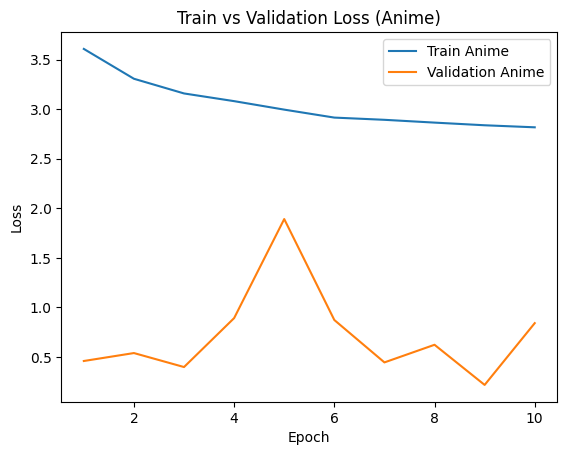

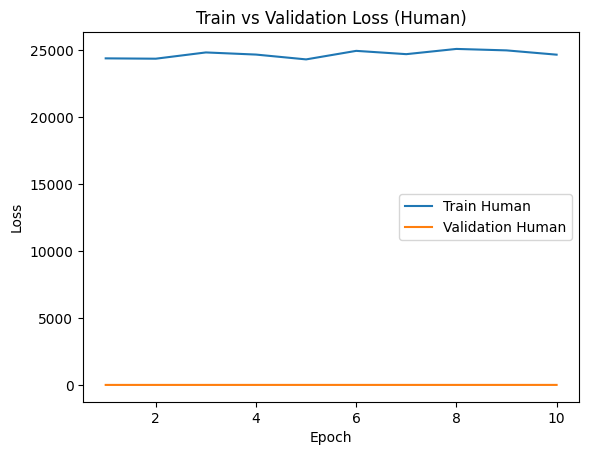

In [29]:
gan_model_path = get_model_name("loss", epoch=15, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
plot_training_curve(gan_model_path)